In [1]:
import os
import glob
import copy
import math
import matplotlib
import multiprocessing

import numpy as np
import pandas as pd
import scipy.integrate as integrate
import PersistenceImages.persistence_images as pimg

import scipy.signal

from ripser import Rips
from matplotlib import cm
from scipy.io import loadmat
from scipy.stats import norm
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

matplotlib.rcParams['axes.linewidth'] = 1.0
matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 2
matplotlib.rcParams['xtick.minor.width'] = 1

plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

#### Helper Functions

In [2]:
def read_pos(fpath):
    
    data_dict = np.load(fpath)
    cell_pos = data_dict["pos"]
    cell_type = data_dict["types"]
    
    all_xpos = cell_pos[:,0]
    all_ypos = cell_pos[:,1]
    
    t1_idx = np.where(cell_type == 1)[0]
    t2_idx = np.where(cell_type == 2)[0]

    t1_xpos = cell_pos[t1_idx,0]
    t1_ypos = cell_pos[t1_idx,1]
    
    t2_xpos = cell_pos[t2_idx,0]
    t2_ypos = cell_pos[t2_idx,1]
    
    return (t1_xpos, t1_ypos, t2_xpos, t2_ypos, all_xpos, all_ypos)

def compute_dim0_img(greenxpos, greenypos, redxpos, redypos, xpos, ypos, max_eps, px_res):
    
    vrc = Rips(maxdim = 0, thresh = max_eps, verbose = False)
    green_diag = vrc.fit_transform(np.transpose(np.array([greenxpos, greenypos])))
    red_diag = vrc.fit_transform(np.transpose(np.array([redxpos, redypos])))
    all_diag = vrc.fit_transform(np.transpose(np.array([xpos, ypos])))
    
    # remove inf
    green_diag[0] = green_diag[0][:-1]
    red_diag[0] = red_diag[0][:-1]
    all_diag[0] = all_diag[0][:-1]
    
    pers_imager = pimg.PersistenceImager()
    pers_imager.pixel_size = px_res
    pers_imager.birth_range = (0, 1)
    pers_imager.pers_range = (0, max_eps)
    pers_imager.weight = pimg.weighting_fxns.persistence
    pers_imager.weight_params = {'n': 1}
    pers_imager.kernel_params = {'sigma': 0.05}
    
    green_pers_img = pers_imager.transform(green_diag[0], skew=False)
    red_pers_img = pers_imager.transform(red_diag[0], skew=False)
    all_pers_img = pers_imager.transform(all_diag[0], skew=False)
    
    return (green_pers_img, red_pers_img, all_pers_img)

def persistence_diag(greenxpos, greenypos, redxpos, redypos, xpos, ypos, max_eps, max_dim):
    
    vrc = Rips(maxdim = max_dim, thresh = max_eps, verbose = False)
    green_diag = vrc.fit_transform(np.transpose(np.array([greenxpos, greenypos])))
    red_diag = vrc.fit_transform(np.transpose(np.array([redxpos, redypos])))
    all_diag = vrc.fit_transform(np.transpose(np.array([xpos, ypos])))
    
    return (green_diag, red_diag, all_diag)

#### Params

In [3]:
max_eps = 20/2
px_res = 0.1
xs = range(0, int(max_eps/px_res))
xs = [x*px_res for x in xs]
xs = np.round(xs, decimals=2)

method = "heuristic"

### TDA of Stripe Patterns

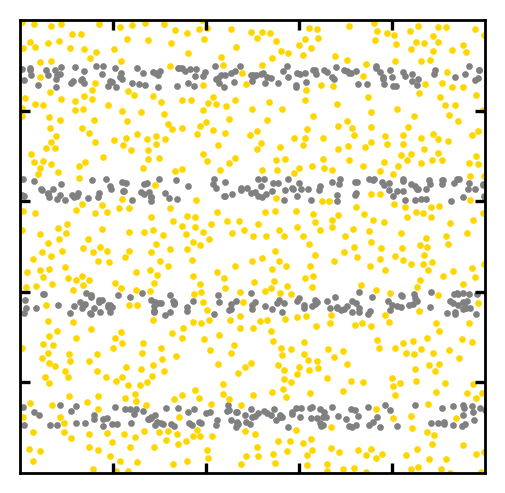

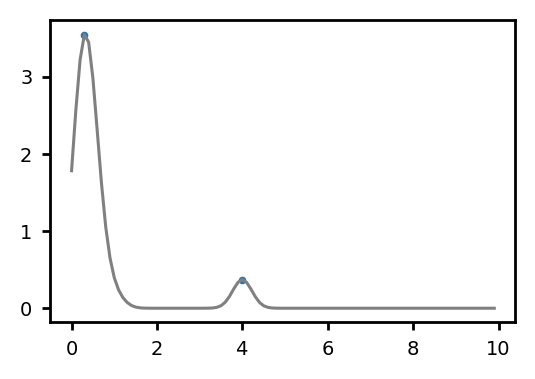

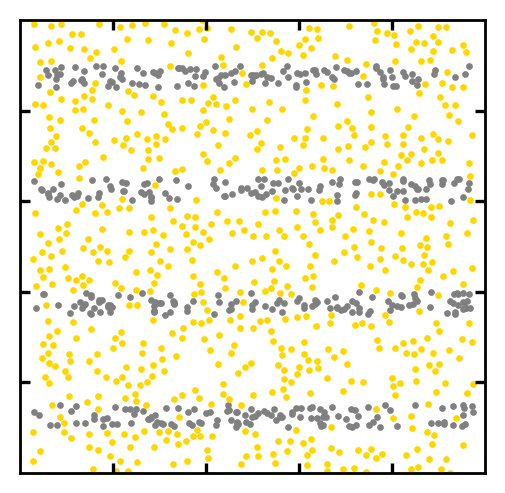

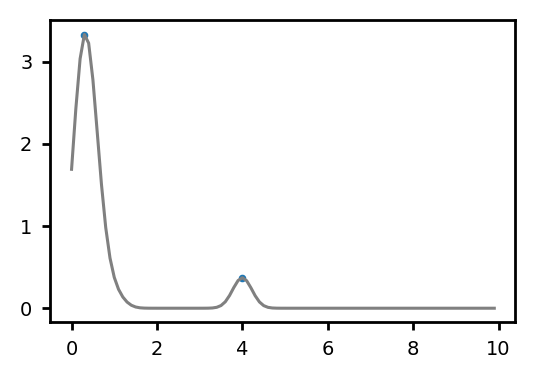

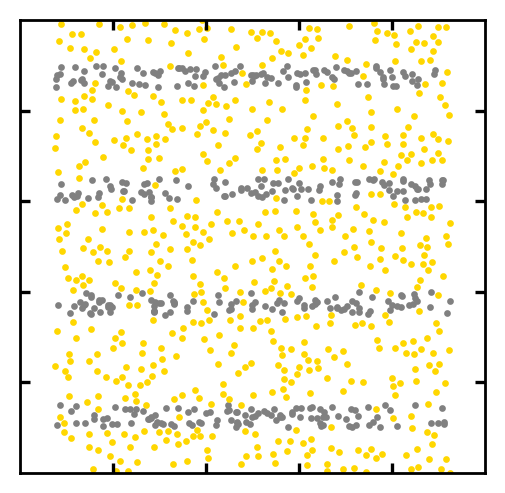

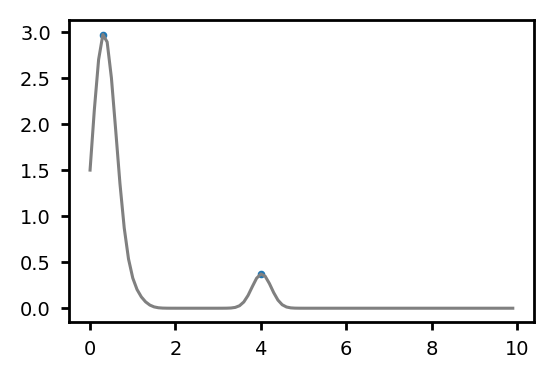

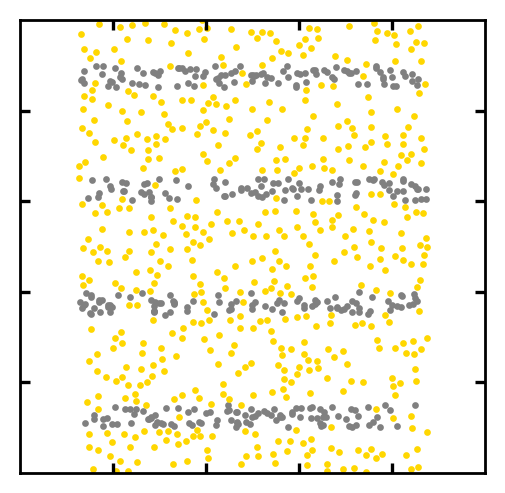

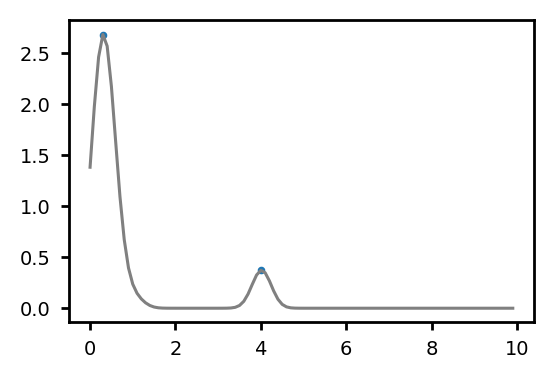

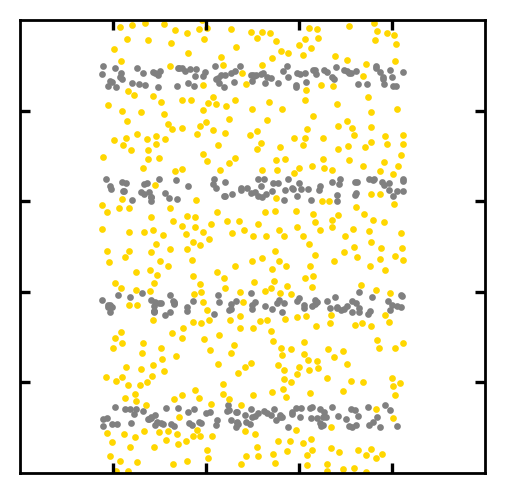

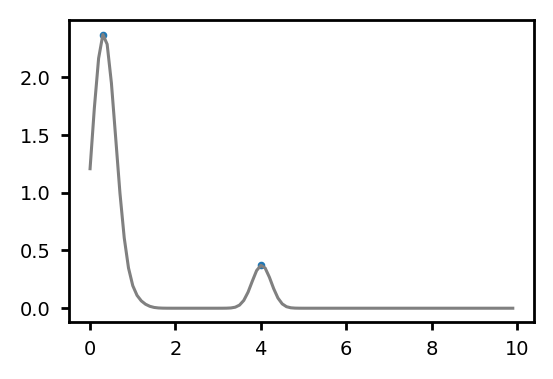

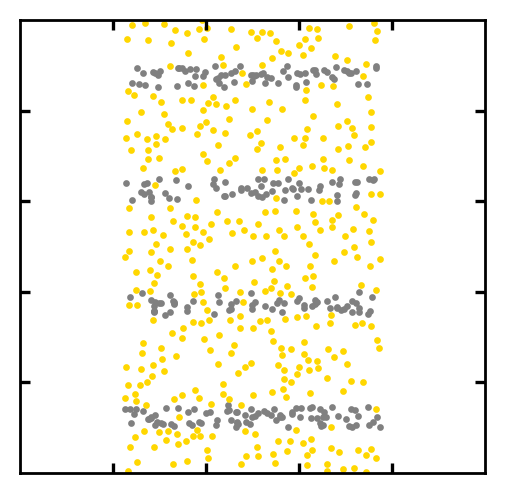

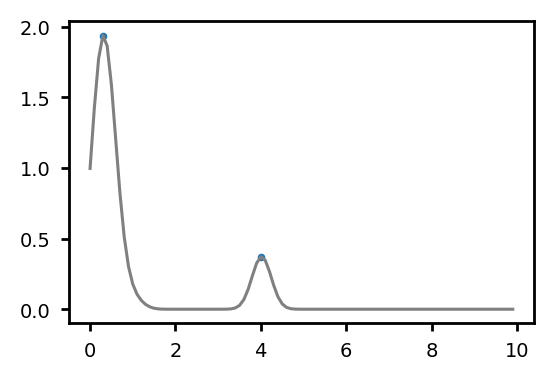

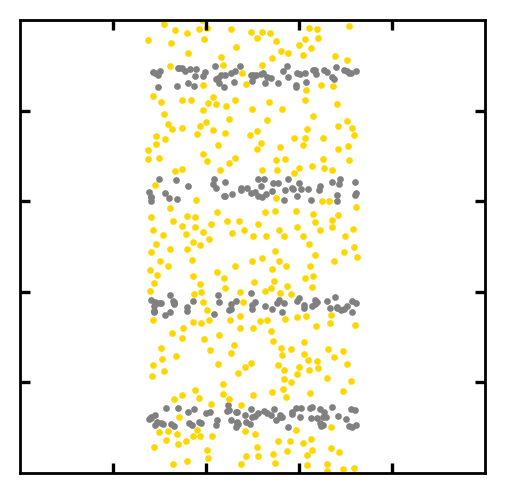

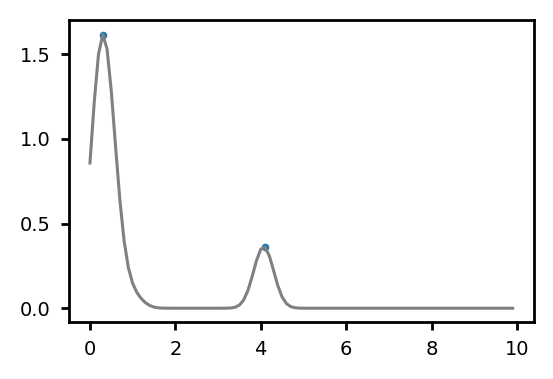

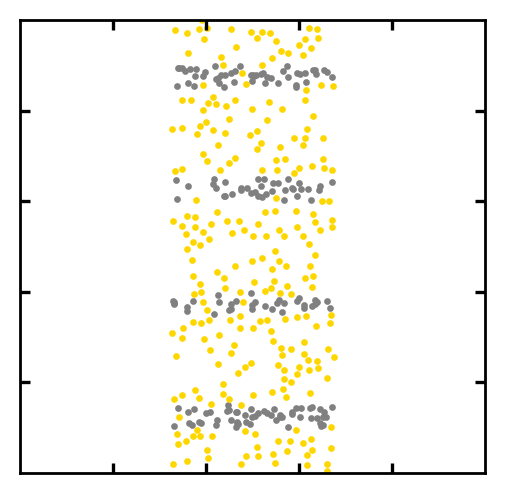

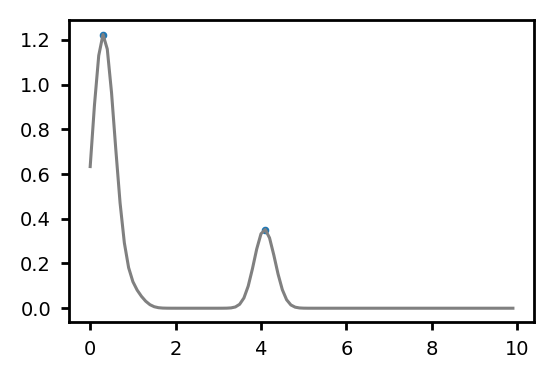

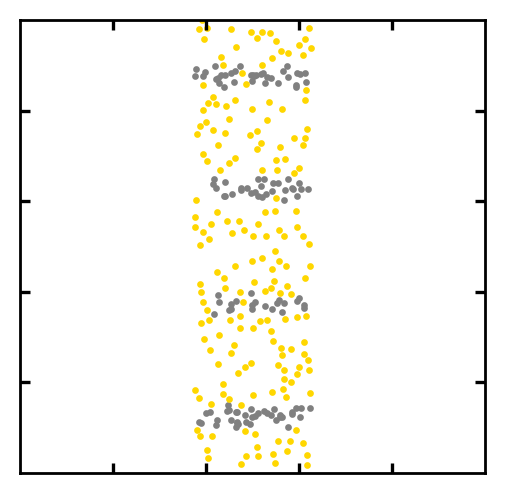

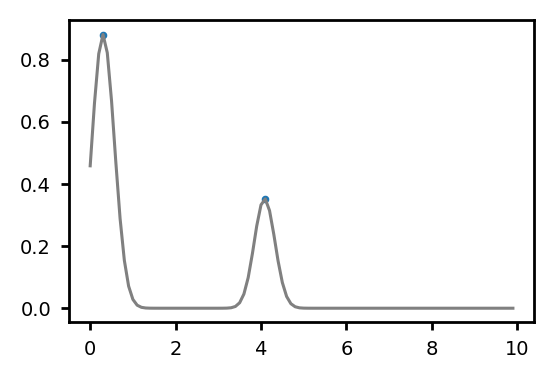

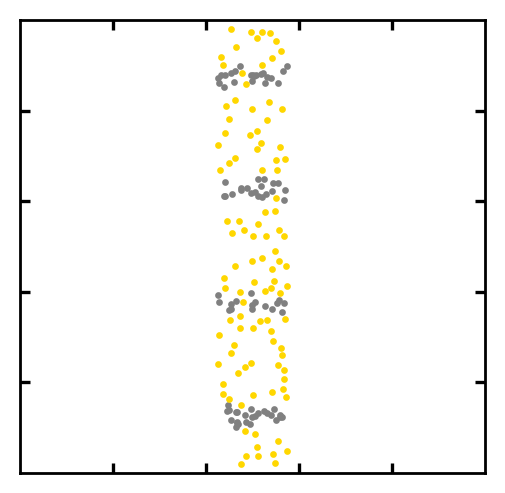

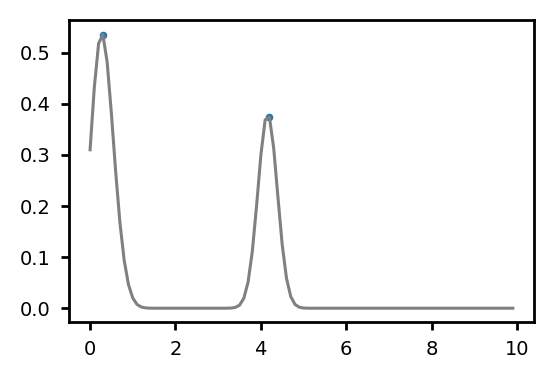

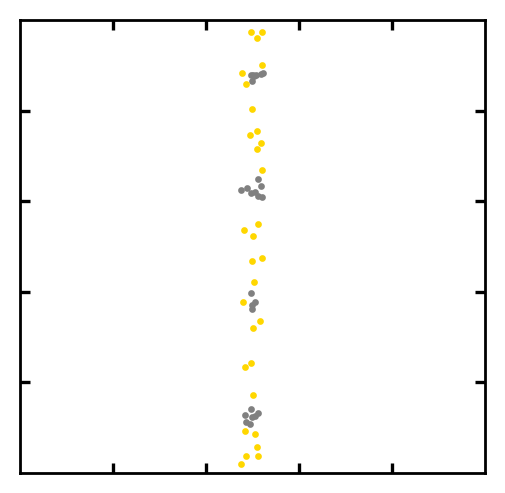

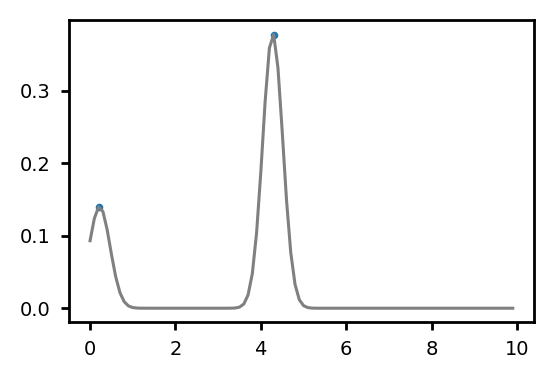

In [4]:
parent_folder = '../h_crop'
num_reps = 5

num_stripes = {}
stripe_width_var = {}
sin_amp = {}
sin_phase_var = {}
sin_omega = {}
frac_crop = {}

PI_dim0_t1 = {}

delta_p1 = {}
delta_p2 = {}
p1 = {}
p2 = {}
Ip1 = {}
Ip2 = {}

interparticle_dist_avg = {}
interstripe_dist_avg = {}

for rep in range(num_reps):
    
    storage_folder = parent_folder + os.sep + repr(rep + 1)

    npy_files = glob.glob(storage_folder + os.sep + '*.npz')

    npy_timestamps = []

    for npy_file in npy_files:

        file_basename = os.path.basename(npy_file)
        file_name = file_basename.split('.')[0]
        npy_timestamps.append(int(file_name.split('_')[2]))

    perm_idx = np.argsort(npy_timestamps)

    fpaths = [npy_files[idx] for idx in perm_idx]
    
    num_stripes[rep] = []
    stripe_width_var[rep] = []
    sin_amp[rep] = []
    sin_phase_var[rep] = []
    sin_omega[rep] = []
    frac_crop[rep] = []

    PI_dim0_t1[rep] = []

    delta_p1[rep] = []
    delta_p2[rep] = []
    p1[rep] = []
    p2[rep] = []
    Ip1[rep] = []
    Ip2[rep] = []
    
    interparticle_dist_avg[rep] = []
    interstripe_dist_avg[rep] = []
    
    for fpath in fpaths:
    
        (t1_xpos, t1_ypos, t2_xpos, t2_ypos, all_xpos, all_ypos) = read_pos(fpath)

        data_dict = np.load(fpath)
        num_stripes[rep].append(data_dict['num_stripes'])
        stripe_width_var[rep].append(data_dict['stripe_width_var'])
        sin_amp[rep].append(data_dict['sin_amp'])
        sin_phase_var[rep].append(data_dict['sin_phase_var'])
        sin_omega[rep].append(data_dict['sin_omega'])
        
        frac_crop[rep].append(data_dict['crop_fraction'])
        
        interparticle_dist_avg[rep].append(data_dict['interparticle_dist_avg'])
        interstripe_dist_avg[rep].append(data_dict['interstripe_dist_avg'])

        (t1_img, t2_img, all_img) = compute_dim0_img(t1_xpos, t1_ypos, t2_xpos, t2_ypos, all_xpos, all_ypos, 
                                                     max_eps, px_res)

        TDA_sig = t1_img[0]

        PI_dim0_t1[rep].append(TDA_sig)

        if method == "wavelet":
            dyadic_scales = np.array([math.pow(2,sc) for sc in [-3, -2, -1, 0, 1]])
            wavelet_window_widths = (dyadic_scales  * (len(xs)/np.max(xs))).astype(int)

            i_pk = scipy.signal.find_peaks_cwt(TDA_sig, widths=wavelet_window_widths, 
                                               wavelet=scipy.signal.gaussian)

            pk_prominence = scipy.signal.peak_prominences(TDA_sig, i_pk)
            pk_widths = scipy.signal.peak_widths(TDA_sig, i_pk, rel_height=1.0)

        elif method == "heuristic":
            i_pk = list(scipy.signal.argrelmax(TDA_sig, axis=0, order=10)[0])
            pk_widths = scipy.signal.peak_widths(TDA_sig, i_pk, rel_height=1.0)

        else:
            print("WARN: Invalid peak computation method!")

        if len(i_pk) >= 2: 
            delta_p1[rep].append(pk_widths[0][0] * px_res)
            delta_p2[rep].append(pk_widths[0][1] * px_res)
            p1[rep].append(xs[i_pk[0]])
            p2[rep].append(xs[i_pk[1]])
            Ip1[rep].append(TDA_sig[i_pk[0]])
            Ip2[rep].append(TDA_sig[i_pk[1]])
        elif len(i_pk) == 1:
            delta_p1[rep].append(pk_widths[0][0] * px_res)
            delta_p2[rep].append(None)
            p1[rep].append(xs[i_pk[0]])
            p2[rep].append(None)
            Ip1[rep].append(TDA_sig[i_pk[0]])
            Ip2[rep].append(None)
        else:
            delta_p1[rep].append(None)
            delta_p2[rep].append(None)
            p1[rep].append(None)
            p2[rep].append(None)
            Ip1[rep].append(None)
            Ip2[rep].append(None)

        if rep == 0:

            plt.figure(figsize=(3,3), dpi=200)
            plt.scatter(t1_xpos, t1_ypos, s=2, color='gray')
            plt.scatter(t2_xpos, t2_ypos, s=2, color='gold')
            plt.xlim([-10,10])
            plt.ylim([-10,10])
            plt.xticks([-6,-2,2,6], [])
            plt.yticks([-6,-2,2,6], [])
            plt.tick_params(direction="in", length=3.5, width=1.2, top=True, right=True)
            plt.show()

            plt.figure(figsize=(3,2), dpi=200)
            plt.plot(xs, TDA_sig, color='gray', linewidth=1.1)
            plt.scatter(xs[i_pk], TDA_sig[i_pk], s=3)
            #plt.plot(xs, t1_img[0], color='gray', linewidth=0.8)
            #plt.plot(xs, t2_img[0], color='gold', linewidth=0.8)
            #plt.plot(xs, all_img[0], '--', color='b', linewidth=0.8)
            plt.show()

In [5]:
xparam = [round(1.0-float(x), 2) for x in frac_crop[0]]
xparam_text = "% Cropped"

In [6]:
xparam

[0.0, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

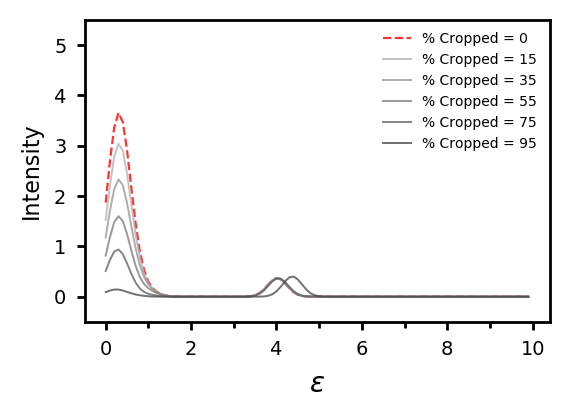

In [7]:
gray_cmap = cm.get_cmap('gist_yarg', 256)
gray_colors = gray_cmap(np.linspace(0, 1, len(PI_dim0_t1[0])))
gray_colors[0] = [1.0,0.2,0.2, 1.0]
gray_colors[2] = [0.7,0.7,0.7, 1.0]
gray_colors[4] = [0.6,0.6,0.6, 1.0]
gray_colors[6] = [0.5,0.5,0.5, 1.0]
gray_colors[8] = [0.4,0.4,0.4, 1.0]
gray_colors[10] = [0.3,0.3,0.3, 1.0]
gray_listed_cmp = ListedColormap(gray_colors)

plt.figure(figsize=(3,2), dpi=200)

for ifig in range(len(PI_dim0_t1[0])):
    if ifig % 2 ==0:
        plt_label = xparam_text + " = " + str(int(xparam[ifig]*100))
        if ifig == 0:
            plt.plot(xs, PI_dim0_t1[3][ifig], linewidth=0.8, linestyle="--", 
                     color=gray_colors[ifig], label=plt_label)
        else:
            plt.plot(xs, PI_dim0_t1[3][ifig], linewidth=0.7, color=gray_colors[ifig], label=plt_label, alpha=0.8)

ax = plt.gca()
ax.set_xticks([1, 3, 5, 7, 9], minor=True)
plt_ylim = ax.get_ylim()
   
plt.xlabel("$\epsilon$")
plt.ylabel("Intensity", fontsize=8)
plt.legend(fontsize=5, frameon=False)
plt.ylim([-0.5, 5.5])
plt.show()

In [8]:
def compute_stats(feat):
    
    feat_repeats = len(feat.keys())
    
    feat_size = len(feat[0])
    feat_mean = np.zeros(feat_size)
    feat_std = np.zeros(feat_size)
    
    for rep in range(feat_repeats):
        
        for i in range(feat_size):
            
            if feat[rep][i] is None:
                feat_mean[i] = None
            else:
                if feat_mean[i] is not None:
                    feat_mean[i] += feat[rep][i]
    
    feat_mean = np.divide(feat_mean, feat_repeats)
    
    for i in range(feat_size):
        
        if ~np.isnan(feat_mean[i]):
            
            std_vals = []
            for rep in range(feat_repeats):
                std_vals.append(feat[rep][i])
            feat_std[i] = np.std(std_vals)
            
    return (feat_mean, feat_std)

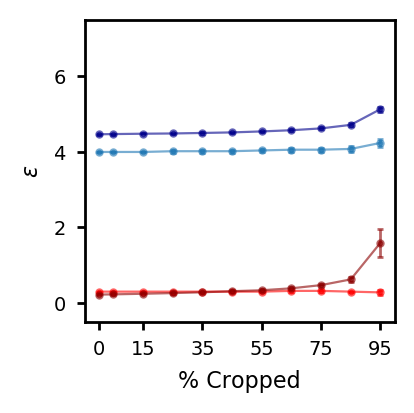

In [9]:
plt.figure(figsize=(2,2), dpi=200)

(p1_mean, p1_std) = compute_stats(p1)
(p2_mean, p2_std) = compute_stats(p2)

(IPD_mean, IPD_std) = compute_stats(interparticle_dist_avg)
(ISD_mean, ISD_std) = compute_stats(interstripe_dist_avg)

p2_mean_nan = []
for key in range(5):
    p2_mean_nan.append(np.nanmean(np.array(p2[key], dtype=np.float)))

#plt.plot(xparam, p2_mean_nan, '--', color='#1f77b4')

plt.errorbar(xparam, p1_mean, p1_std, color='red', label="$P_1$", marker=".", markersize=4, 
             alpha=0.6, elinewidth=1.0, capsize=1.2, linewidth=0.8)

plt.errorbar(xparam, p2_mean, p2_std, color='#1f77b4', label="$P_2$", marker=".", markersize=4, 
             alpha=0.6, elinewidth=1.0, capsize=1.2, linewidth=0.8)

plt.errorbar(xparam, ISD_mean, ISD_std, color='darkblue', label="Stripe Separation", marker=".", markersize=4, 
             alpha=0.6, elinewidth=1.0, capsize=1.2, linewidth=0.8)

plt.errorbar(xparam, IPD_mean, IPD_std, color='darkred', label="Interparticle Dist", marker=".", markersize=4, 
             alpha=0.6, elinewidth=1.0, capsize=1.2, linewidth=0.8)

#plt.legend(fontsize=6, frameon=False)
xlab_pos = [0, 0.15, 0.35, 0.55, 0.75, 0.95]
xlab_disp = [str(int(100*xlab_p)) for xlab_p in xlab_pos]
plt.xticks(xlab_pos, xlab_disp)
plt.xlabel(xparam_text, fontsize=8)
plt.ylabel("$\epsilon$", fontsize=8)
plt.ylim([-0.5, 7.5])
plt.show()

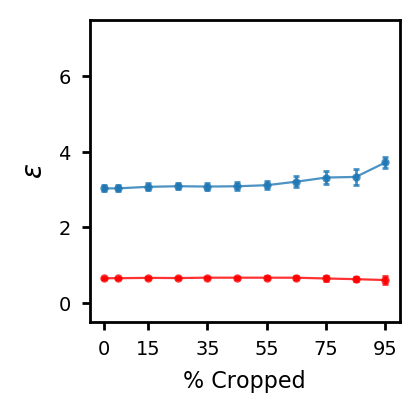

In [10]:
plt.figure(figsize=(2,2), dpi=200)

(delta_p1_mean, delta_p1_std) = compute_stats(delta_p1)
(delta_p2_mean, delta_p2_std) = compute_stats(delta_p2)

#plt.plot(xparam, delta_p1_mean, '--', color='red')
#plt.plot(xparam, delta_p2_mean, '--', color='#1f77b4')

plt.errorbar(xparam, delta_p1_mean, delta_p1_std, color='red', label="$\Delta(P_1)$", marker=".", 
             markersize=4, alpha=0.8, elinewidth=1.0, capsize=1.2, linewidth=0.8)
plt.errorbar(xparam, delta_p2_mean, delta_p2_std, color='#1f77b4', label="$\Delta(P_2)$", marker=".", 
             markersize=4, alpha=0.8, elinewidth=1.0, capsize=1.2, linewidth=0.8)

#plt.legend(fontsize=6, frameon=False)
xlab_pos = [0, 0.15, 0.35, 0.55, 0.75, 0.95]
xlab_disp = [str(int(100*xlab_p)) for xlab_p in xlab_pos]
plt.xticks(xlab_pos, xlab_disp)
plt.xlabel(xparam_text, fontsize=8)
plt.ylabel("$\epsilon$")
plt.ylim([-0.5, 7.5])
plt.show()

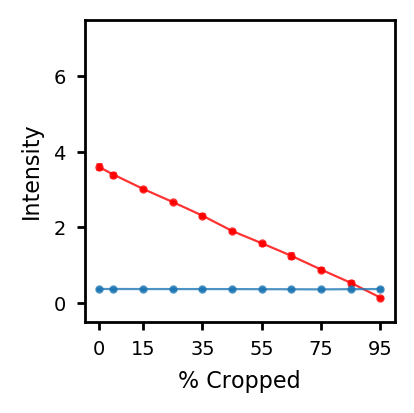

In [11]:
plt.figure(figsize=(2,2), dpi=200)

(Ip1_mean, Ip1_std) = compute_stats(Ip1)
(Ip2_mean, Ip2_std) = compute_stats(Ip2)

plt.errorbar(xparam, Ip1_mean, Ip1_std, color='red', label="$I(P_1)$", marker=".", markersize=4, 
             alpha=0.8, elinewidth=1.0, capsize=1.2, linewidth=0.8)
plt.errorbar(xparam, Ip2_mean, Ip2_std, color='#1f77b4', label="$I(P_2)$", marker=".", markersize=4, 
             alpha=0.8, elinewidth=1.0, capsize=1.2, linewidth=0.8)

#plt.legend(fontsize=6, frameon=False)
xlab_pos = [0, 0.15, 0.35, 0.55, 0.75, 0.95]
xlab_disp = [str(int(100*xlab_p)) for xlab_p in xlab_pos]
plt.xticks(xlab_pos, xlab_disp)
plt.xlabel(xparam_text, fontsize=8)
plt.ylabel("Intensity", fontsize=8)
plt.ylim([-0.5, 7.5])
plt.show()